<a href="https://colab.research.google.com/github/CaesarPCChang/gemini/blob/main/Demura_%E4%BA%AE%E5%BA%A6%E6%A0%A1%E6%AD%A3_Python_%E7%A8%8B%E5%BC%8F%E7%A2%BC%E9%80%90%E8%A1%8C%E8%A9%B3%E8%A7%A3_0713_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulating measurement of 5 grayscale levels...
Measurement simulation complete.
Fitting luminance response model for each pixel...
Model fitting complete.
Calculating target luminance curve...
Target curve coefficients: [2.25486109e-06 9.96165581e-01 2.53044316e+00]
Generating Demura correction Look-Up Table (LUT)...
Correction data generation complete.

--- Evaluation Result ---
Test Gray Level: 191
Uniformity Before Correction: 55.37%
Uniformity After Correction: 96.11%


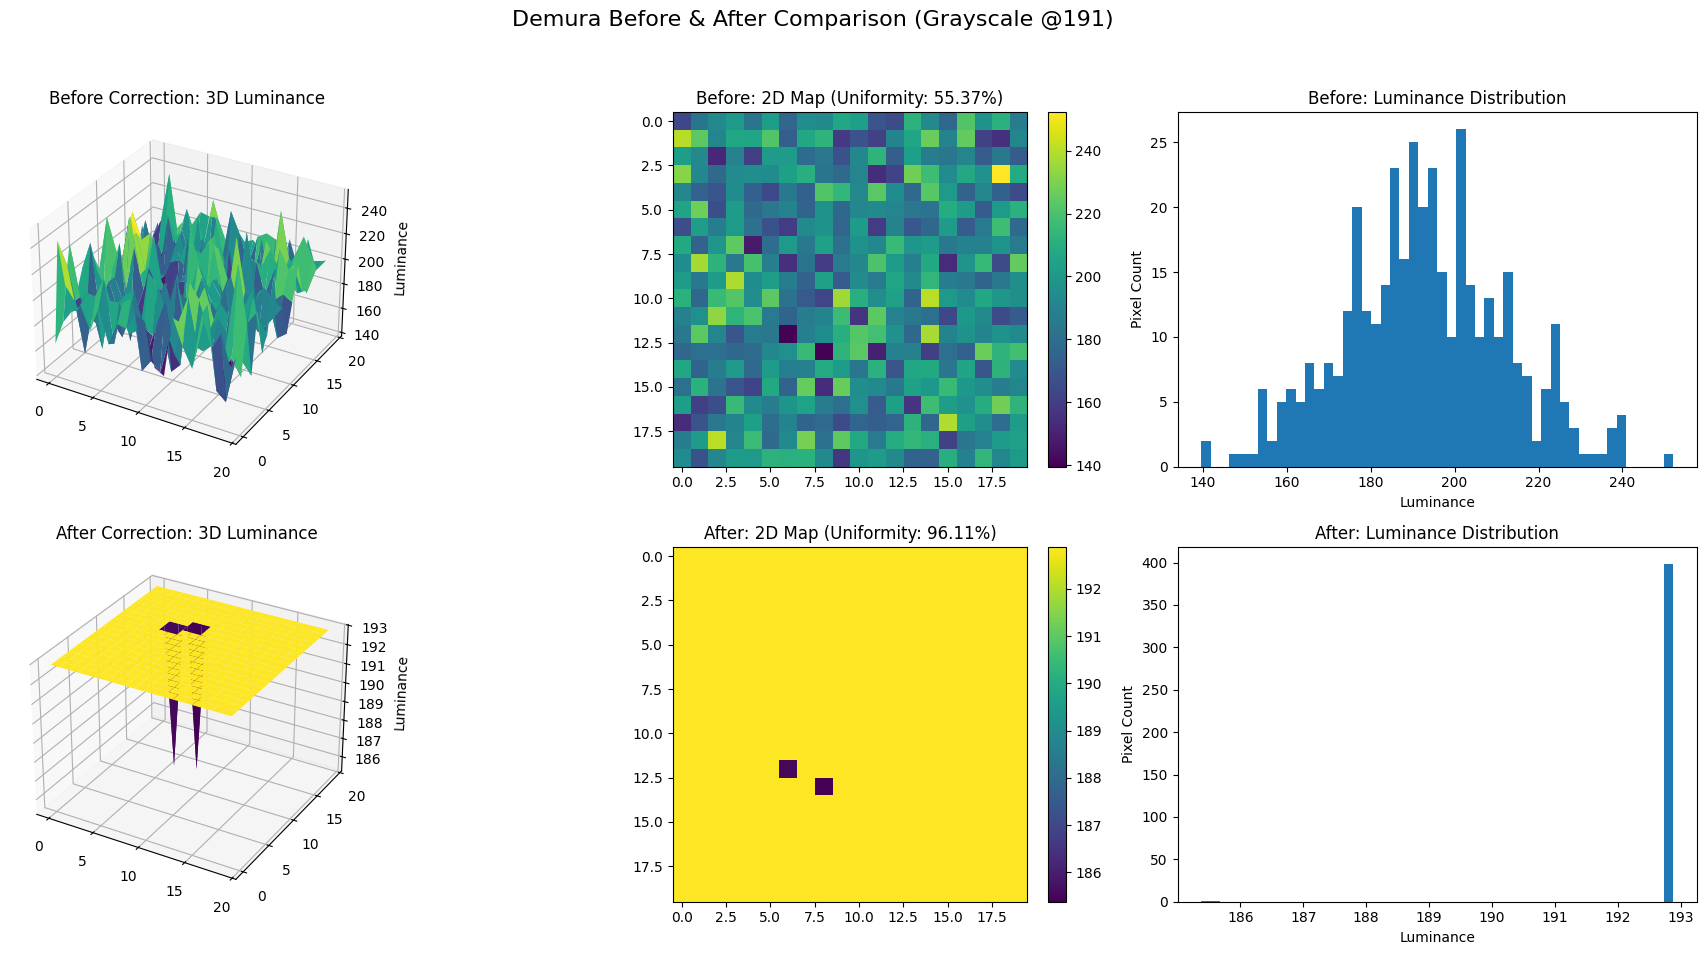

In [1]:
# 匯入 NumPy 函式庫，用於高效的數值與陣列運算，是科學計算的核心。
import numpy as np
# 匯入 Matplotlib 的 pyplot 模組，用於繪製 2D 圖表。
import matplotlib.pyplot as plt
# 從 Matplotlib 匯入 Axes3D，用於繪製 3D 曲面圖。
from mpl_toolkits.mplot3d import Axes3D
# 從 Matplotlib 匯入 cm (colormap)，用於設定圖表的顏色映射。
from matplotlib import cm

# --- 0. 基本設定 (Basic Settings) ---
# 設定面板尺寸為 20x20 的像素矩陣。
PANEL_SIZE = (20, 20)
# 定義將要進行量測的 5 個代表性灰階點。這些點的選擇應能有效覆蓋整個亮度範圍。
MEASURED_GRAYS = np.array([31, 63, 127, 191, 255])
# 產生一個從 0 到 255 的陣列，代表 8-bit 的所有灰階等級。
ALL_GRAYS = np.arange(256)
# 設定用於擬合亮度響應曲線的多項式階數。二次多項式是精度與計算複雜度的良好平衡點。
# 物理意義：LED 的亮度響應通常不是完美的線性，使用二次多項式可以更好地描述其輕微的曲線特性。
# 數學模型：L(g) = a*g^2 + b*g + c，其中 L 是亮度，g 是灰階。
POLY_DEGREE = 2

# --- 1. 模擬面板原始特性 (Simulate Original Panel Characteristics) ---
# 設定隨機數種子，確保每次執行程式時產生的隨機數都相同，以便重現結果。
np.random.seed(42)
# 為每個像素(20x20)的二次項係數 'a' 產生一個微小的隨機誤差。
# 數學公式：a_ij = 0 + 0.0001 * N(0,1)，其中 N(0,1) 是標準常態分佈隨機數。
poly_coeffs_a = 0.0001 * np.random.randn(*PANEL_SIZE)
# 為每個像素的線性項係數 'b' 產生隨機誤差。這是 Mura (不均勻) 的主要來源。
# 數學公式：b_ij = 1 + 0.1 * N(0,1)。理想情況下 b=1，這裡模擬了效率的偏差。
poly_coeffs_b = 1 + 0.1 * np.random.randn(*PANEL_SIZE)
# 為每個像素的常數項係數 'c' 產生隨機誤差，模擬暗態下的漏光。
# 數學公式：c_ij = 5 * U(0,1)，其中 U(0,1) 是 0 到 1 之間的均勻分佈隨機數。
poly_coeffs_c = 5 * np.random.rand(*PANEL_SIZE)

# 定義一個函數，用來計算面板在給定灰階下的原始(未校正)亮度。
def get_original_luminance(gray_level, coeffs_a, coeffs_b, coeffs_c):
    """根據給定的多項式係數，計算指定灰階的原始亮度"""
    # 核心原理：對整個面板(矩陣)進行元素級的運算，一次性計算出所有像素的亮度。
    # 數學公式：L_ij(g) = a_ij * g^2 + b_ij * g + c_ij
    # 此處的 g (gray_level) 是純量，而係數是 20x20 矩陣，Numpy 的廣播(broadcasting)機制會自動處理運算。
    return coeffs_a * gray_level**2 + coeffs_b * gray_level + coeffs_c

# --- 2. 產生模擬的面板量測資料 (Generate Simulated Measurement Data) ---
# 初始化一個三維陣列(20x20x5)來儲存量測數據，維度分別是(行, 列, 量測的灰階點)。
measured_luminance_data = np.zeros((*PANEL_SIZE, len(MEASURED_GRAYS)))
# 輸出提示訊息，告知使用者程式正在進行哪一步。
print(f"Simulating measurement of {len(MEASURED_GRAYS)} grayscale levels...")
# 使用 enumerate 遍歷 MEASURED_GRAYS，同時獲得索引 i 和灰階值 g。
for i, g in enumerate(MEASURED_GRAYS):
    # 呼叫先前定義的函數，計算在灰階 g 時整個面板的亮度分佈。
    # 並將結果存儲到 `measured_luminance_data` 的第 i 個切片中。
    measured_luminance_data[:, :, i] = get_original_luminance(g, poly_coeffs_a, poly_coeffs_b, poly_coeffs_c)
# 輸出提示訊息，告知使用者模擬量測已完成。
print("Measurement simulation complete.")

# --- 3. Demura 演算法核心：為每個子像素擬合亮度模型 ---
# 輸出提示訊息。
print("Fitting luminance response model for each pixel...")
# 初始化一個三維陣列(20x20x3)來儲存每個像素擬合後的多項式係數 (a, b, c)。
# POLY_DEGREE 是 2，所以需要 2+1=3 個係數。
fitted_coeffs = np.zeros((*PANEL_SIZE, POLY_DEGREE + 1))

# 遍歷面板的每一行。
for r in range(PANEL_SIZE[0]):
    # 遍歷面板的每一列。
    for c in range(PANEL_SIZE[1]):
        # 提取當前像素 (r, c) 在 5 個量測灰階點下的亮度值。
        pixel_luminance = measured_luminance_data[r, c, :]
        # 核心步驟：使用 np.polyfit 進行多項式擬合。
        # 原理：它使用「最小平方法」來找到一組多項式係數，使得擬合曲線與實際數據點之間的平方誤差和最小。
        # 數學目標：min Σ( (a*g_i^2 + b*g_i + c) - L_i )^2，其中 i 是量測點的索引。
        # 輸入：x 座標 (MEASURED_GRAYS), y 座標 (pixel_luminance), 階數 (POLY_DEGREE)。
        # 輸出：一個包含 [a, b, c] 係數的陣列。
        coeffs = np.polyfit(MEASURED_GRAYS, pixel_luminance, POLY_DEGREE)
        # 將擬合得到的係數存儲到對應像素的位置。
        fitted_coeffs[r, c, :] = coeffs
# 輸出提示訊息。
print("Model fitting complete.")

# --- 4. 計算目標亮度曲線 ---
# 輸出提示訊息。
print("Calculating target luminance curve...")
# 計算在每個量測灰階點上，整個面板所有像素的「平均亮度」。
# axis=(0, 1) 表示沿著第 0 和第 1 維度 (行和列) 進行平均，保留第 2 維度 (灰階點)。
# 結果是一個長度為 5 的陣列，代表了面板的平均響應。
mean_luminance_at_measured_grays = np.mean(measured_luminance_data, axis=(0, 1))
# 同樣使用 polyfit，擬合這條代表了「理想」或「目標」的平均亮度曲線。
# 這樣我們就得到了一組目標係數 [a_t, b_t, c_t]，代表了校正後的統一標準。
target_coeffs = np.polyfit(MEASURED_GRAYS, mean_luminance_at_measured_grays, POLY_DEGREE)
# 輸出目標曲線的係數。
print(f"Target curve coefficients: {target_coeffs}")

# 定義一個函數，用來計算在任意目標灰階下的目標亮度。
def get_target_luminance(gray_level, coeffs):
    """根據目標係數，計算目標亮度"""
    # np.poly1d 將係數陣列轉換為一個可呼叫的多項式物件。
    p = np.poly1d(coeffs)
    # 傳入灰階值，計算多項式的值，即目標亮度 L_target。
    return p(gray_level)

# --- 5. 計算所有255個灰階的校正資料 (LUT Generation) ---
# 輸出提示訊息。
print("Generating Demura correction Look-Up Table (LUT)...")
# 初始化一個三維陣列(20x20x256)來儲存最終的查找表(LUT)。
demura_lut = np.zeros((*PANEL_SIZE, len(ALL_GRAYS)))

# 遍歷所有可能的目標灰階值 g_target (0 到 255)。
for g_target in ALL_GRAYS:
    # 對於當前的 g_target，計算其對應的「目標亮度」l_target。
    l_target = get_target_luminance(g_target, target_coeffs)

    # 從擬合的係數矩陣中，分離出所有像素的 a, b, c 係數。
    a = fitted_coeffs[:, :, 0]
    b = fitted_coeffs[:, :, 1]
    # 核心原理：我們要解方程式 L_pixel(g_corrected) = l_target
    # 即 a*g_corrected^2 + b*g_corrected + c_pixel = l_target
    # 移項後得到標準一元二次方程：a*x^2 + b*x + (c_pixel - l_target) = 0
    # 所以這裡的常數項是 c_pixel 減去 l_target。
    c = fitted_coeffs[:, :, 2] - l_target

    # 使用 with np.errstate 來暫時忽略因開根號負數而產生的警告，我們會在後面處理這些無實數解的情況。
    with np.errstate(invalid='ignore'):
        # 計算一元二次方程的判別式 (Discriminant)。
        # 數學公式：Δ = b^2 - 4ac
        delta = b**2 - 4*a*c

        # 使用求根公式計算方程的解。
        # 數學公式：x = (-b ± sqrt(Δ)) / 2a
        # 物理意義：灰階值必然隨亮度增加而增加，因此我們取正號的解。
        g_corrected1 = (-b + np.sqrt(delta)) / (2 * a)

    # 將計算出的解賦值給 g_corrected。
    g_corrected = g_corrected1

    # 使用 np.clip 函數，將計算出的校正值限制在 [0, 255] 的有效範圍內。
    # 對於無實數解(delta < 0)導致的 NaN (Not a Number) 或超出範圍的值，此步驟會將它們修正為 0 或 255。
    demura_lut[:, :, g_target] = np.clip(g_corrected, 0, 255)

# 輸出提示訊息。
print("Correction data generation complete.")

# --- 6. 評估與視覺化 (Evaluation and Visualization) ---
# 定義一個函數來計算亮度均勻度。
def calculate_uniformity(luminance_map):
    """Calculates luminance uniformity using the specified metric."""
    # 找到亮度圖中的最小值。
    min_lum = np.min(luminance_map)
    # 找到亮度圖中的最大值。
    max_lum = np.max(luminance_map)
    # 如果最大亮度為0，為避免除以零錯誤，直接返回 100%。
    if max_lum == 0:
        return 100.0
    # 核心公式：Uniformity = (最小亮度 / 最大亮度) * 100%
    return (min_lum / max_lum) * 100.0

# 選擇一個灰階 (例如 191) 來進行校正前後的對比。
GRAY_LEVEL_FOR_TEST = 191

# --- 校正前 ---
# 計算原始面板在測試灰階下的亮度分佈圖。
original_lum_map = get_original_luminance(GRAY_LEVEL_FOR_TEST, poly_coeffs_a, poly_coeffs_b, poly_coeffs_c)
# 計算校正前的均勻度。
original_uniformity = calculate_uniformity(original_lum_map)

# --- 校正後 ---
# 模擬校正過程：
# 1. 當外部訊號要求顯示灰階 191 時，系統從 Demura LUT 中查找每個像素對應的「校正後灰階值」。
corrected_gray_values = demura_lut[:, :, GRAY_LEVEL_FOR_TEST]
# 2. 將這些「校正後」的灰階值輸入到「真實」的面板物理模型中，得到最終顯示的亮度。
corrected_lum_map = get_original_luminance(corrected_gray_values, poly_coeffs_a, poly_coeffs_b, poly_coeffs_c)
# 計算校正後的均勻度。
corrected_uniformity = calculate_uniformity(corrected_lum_map)

# 輸出評估結果。
print("\n--- Evaluation Result ---")
print(f"Test Gray Level: {GRAY_LEVEL_FOR_TEST}")
print(f"Uniformity Before Correction: {original_uniformity:.2f}%")
print(f"Uniformity After Correction: {corrected_uniformity:.2f}%")

# --- 視覺化 ---
# 創建一個大的圖形畫布，尺寸為 18x10 英吋。
fig = plt.figure(figsize=(18, 10))
# 為整個圖形設置一個主標題。
fig.suptitle(f'Demura Before & After Comparison (Grayscale @{GRAY_LEVEL_FOR_TEST})', fontsize=16)

# 在 2x3 的網格中，創建第 1 個子圖，並設定為 3D 投影。
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
# 創建網格點座標，用於繪製 3D 曲面。
X, Y = np.meshgrid(range(PANEL_SIZE[1]), range(PANEL_SIZE[0]))
# 繪製校正前的 3D 亮度曲面圖。
surf1 = ax1.plot_surface(X, Y, original_lum_map, cmap=cm.viridis)
# 設定子圖標題。
ax1.set_title('Before Correction: 3D Luminance')
# 設定 Z 軸標籤。
ax1.set_zlabel('Luminance')

# 創建第 2 個子圖。
ax2 = fig.add_subplot(2, 3, 2)
# 使用 imshow 繪製校正前的 2D 亮度熱圖。
im2 = ax2.imshow(original_lum_map, cmap='viridis')
# 設定子圖標題，並在標題中顯示均勻度數值。
ax2.set_title(f'Before: 2D Map (Uniformity: {original_uniformity:.2f}%)')
# 為 2D 圖添加顏色條 (colorbar)。
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

# 創建第 3 個子圖。
ax3 = fig.add_subplot(2, 3, 3)
# 將 2D 亮度圖攤平成一維陣列，並繪製其分佈的直方圖。
ax3.hist(original_lum_map.flatten(), bins=50)
# 設定子圖標題。
ax3.set_title('Before: Luminance Distribution')
# 設定 X 軸標籤。
ax3.set_xlabel('Luminance')
# 設定 Y 軸標籤。
ax3.set_ylabel('Pixel Count')

# --- 以下為校正後的圖，繪製邏輯與校正前完全相同 ---
# 創建第 4 個子圖 (3D)。
ax4 = fig.add_subplot(2, 3, 4, projection='3d')
# 繪製校正後的 3D 亮度曲面圖。
surf4 = ax4.plot_surface(X, Y, corrected_lum_map, cmap=cm.viridis)
ax4.set_title('After Correction: 3D Luminance')
ax4.set_zlabel('Luminance')

# 創建第 5 個子圖 (2D)。
ax5 = fig.add_subplot(2, 3, 5)
# 繪製校正後的 2D 亮度熱圖。
im5 = ax5.imshow(corrected_lum_map, cmap='viridis')
ax5.set_title(f'After: 2D Map (Uniformity: {corrected_uniformity:.2f}%)')
fig.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)

# 創建第 6 個子圖 (直方圖)。
ax6 = fig.add_subplot(2, 3, 6)
# 繪製校正後的亮度分佈直方圖。
ax6.hist(corrected_lum_map.flatten(), bins=50)
ax6.set_title('After: Luminance Distribution')
ax6.set_xlabel('Luminance')
ax6.set_ylabel('Pixel Count')

# 自動調整子圖佈局，防止標題和標籤重疊。
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# 顯示所有繪製的圖形。
plt.show()